### 專案主題 : 躺平族之相關分析

### 大綱
1. 動機與分析目的
2. 分析方向及工具
3. 基本資料介紹
4. 資料前處理
    - 留言萃取
    - 斷詞
5. LDA 主題模型
    - 模型建立
    - Pyvis視覺化
6. 結論

## 1. 動機與分析目的

### 分析動機：
* 年輕人為何拒絕奮鬥？低消費低生產主義有可能造成國安危機？
* 不再以買房、買車、生小孩為人生目標，「躺平才是唯一的真理」，年輕人對於未來普遍感到失望和無力，探討社會對於躺平現象的接受度和反應
* 分析躺平族現象對經濟活動、就業市場和消費行為的影響（如不消費、低生產），以及它可能對未來經濟發展的影響
* 透過分析PTT閒聊版上的討論，揭露大眾意見的形成與流動過程。分析媒體如何塑造對躺平族的觀點，以及這些觀點在台灣社會中如何傳播與轉變

## 2. 分析方向及工具

### 分析方向
- 主題模型，用來分析輿論主題的類別．

## 3. 基本資料介紹

- 資料來源：文字平台 PTT閒聊板資料
- 資料集：lie-flat.csv
- 關鍵字：躺平族、躺平、不想努力了
- 資料時間：2021-01-01 到 2024-04-18
- 資料量： 625 篇文章

## 4. 資料前處理

套件設定

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint
from snownlp import SnowNLP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# 設定字型
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' 

載入資料

In [5]:
ptt = pd.read_csv("./raw_data/Lie-Flat.csv") 
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt


看看有幾篇文章

In [6]:
print(f"number of posts: {ptt.shape[0]}")
print(f"date range: {(ptt['artDate'].min(), ptt['artDate'].max())}")
print(f"category: \n{ptt['artCatagory'].value_counts()}")


number of posts: 625
date range: ('2021-05-30 11:12:41', '2024-04-15 19:46:25')
category: 
artCatagory
Gossiping      618
prozac           4
China_Drama      2
job              1
Name: count, dtype: int64


### 留言萃取
取出`artComment`的`cmtContent`

In [7]:
ptt = ptt[ptt.artComment != '[]'] # 刪除沒有comment的文章

# 取出 commentContent
def getComtInfo(com):
    cmtContent = ""
    com = eval(com)
    # print(com)
    for i in com:
        # print(i)
        cmtContent += i['cmtContent']
    return pd.Series([cmtContent])


ptt[['cmtContent']] = ptt['artComment'].apply(lambda r: getComtInfo(r))
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,cmtContent
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,:對辣目在演員請就位第二季的表演印象深刻:我覺得戲太多了。像玉桃花也沒人開討論串:不是每檔劇...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt,:感覺是療癒的輕鬆小品，謝謝分享
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt,:停:台灣年輕人領先十年:對岸比較誇張==:台灣更多:這躺平主義怎麼像在講台灣呢:日本的無欲...


清除網址及留下中文字

In [8]:
ptt["artContent"] = ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["artContent"] = ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["cmtContent"] = ptt["cmtContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["cmtContent"] = ptt["cmtContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,cmtContent
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,閒聊沒有工作的一年,2022-05-03 19:54:49,vincentwjs,China_Drama,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,對辣目在演員請就位第二季的表演印象深刻我覺得戲太多了像玉桃花也沒人開討論串不是每檔劇都有人開...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,心得沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt,感覺是療癒的輕鬆小品謝謝分享
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,新聞中國人躺平火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt,停台灣年輕人領先十年對岸比較誇張台灣更多這躺平主義怎麼像在講台灣呢日本的無欲社會也差不多大概...


將 `artTitle`, `artContent`, `cmtContent` 合併成新欄位 `whole_content`

In [9]:
ptt["whole_content"] = ptt["artTitle"] + ptt["artContent"] + ptt["cmtContent"]
ptt = ptt[['system_id', 'artUrl', 'artDate', 'artCatagory', 'whole_content']]

In [10]:
ptt

,system_id,artUrl,artDate,artCatagory,whole_content
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03 19:54:49,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03 14:04:20,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30 11:12:41,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04 20:36:41,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06 18:30:04,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...
...,...,...,...,...,...
618,619,https://www.ptt.cc/bbs/Gossiping/M.1713145120....,2024-04-15 09:38:37,Gossiping,新聞台灣年輕人為何效忠躺平主義網紅台灣年輕人為何效忠躺平主義網紅精闢解析大原因壹蘋記者李雅欣...
619,620,https://www.ptt.cc/bbs/Gossiping/M.1713181587....,2024-04-15 19:46:25,Gossiping,新聞兒科醫臨嚴重人力荒年後重症恐無人治兒科真的這麼慘台大是怎麼收到位住院醫師的兒科確實賺不到...
620,621,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,2022-01-06 12:27:42,job,台北徳勝科技徵行政助理版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同...
623,624,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,2022-10-31 21:10:21,prozac,閒聊人生的意義就是存活很好但是呢躺平族還是很累的要計算最少金錢得到最均衡的養分活著而且生病很...


### 斷詞

設定字典

In [11]:
jieba.set_dictionary('./dict/dict.txt')
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from /Users/wuanjie/Desktop/Text_mining/mid-project/Social_analysis/dict/dict.txt ...
2024-05-17 14:28:46,318 : DEBUG : Building prefix dict from /Users/wuanjie/Desktop/Text_mining/mid-project/Social_analysis/dict/dict.txt ...


Dumping model to file cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.uca9b85b70fe6e8362229ed42b242f451.cache
2024-05-17 14:28:47,234 : DEBUG : Dumping model to file cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.uca9b85b70fe6e8362229ed42b242f451.cache
Loading model cost 0.997 seconds.
2024-05-17 14:28:47,353 : DEBUG : Loading model cost 0.997 seconds.
Prefix dict has been built successfully.
2024-05-17 14:28:47,354 : DEBUG : Prefix dict has been built successfully.


In [15]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")


# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    if not isinstance(row, str):  # 檢查類型是否為字串
        row = str(row)  # 將非字串類型轉換為字串
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ptt["words"] = ptt["whole_content"].apply(getToken)
ptt

Building prefix dict from /Users/wuanjie/Desktop/Text_mining/mid-project/Social_analysis/dict/dict.txt ...
2024-05-17 14:30:16,826 : DEBUG : Building prefix dict from /Users/wuanjie/Desktop/Text_mining/mid-project/Social_analysis/dict/dict.txt ...
Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.uca9b85b70fe6e8362229ed42b242f451.cache
2024-05-17 14:30:16,828 : DEBUG : Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.uca9b85b70fe6e8362229ed42b242f451.cache
Loading model cost 1.391 seconds.
2024-05-17 14:30:18,218 : DEBUG : Loading model cost 1.391 seconds.
Prefix dict has been built successfully.
2024-05-17 14:30:18,225 : DEBUG : Prefix dict has been built successfully.


,system_id,artUrl,artDate,artCatagory,whole_content,words
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03 19:54:49,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...,"[閒聊, 工作, 第集, 沒人開, 這一, 閒聊, 一部, 顛覆, 都市, 情感, 富美, ..."
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03 14:04:20,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...,"[心得, 工作, 滑到, 工作, 打工, 金句, 注意到, 這部, 陸劇, 工作, 總共, ..."
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30 11:12:41,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...,"[中國人, 躺平, 火爆, 網路, 當局, 慌忙, 喊停, 備註, 請放, 違者, 刪除, ..."
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04 20:36:41,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...,"[問卦, 就爛, 說法, 草食, 啃老族, 躺平, 說法, 文雅, 八卦, 配上, 嘲諷, ..."
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06 18:30:04,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...,"[問卦, 具體, 人性, 自私, 利益, 優先, 考量, 不幸, 甜如蜜, 中產階級, 打到..."
...,...,...,...,...,...,...
618,619,https://www.ptt.cc/bbs/Gossiping/M.1713145120....,2024-04-15 09:38:37,Gossiping,新聞台灣年輕人為何效忠躺平主義網紅台灣年輕人為何效忠躺平主義網紅精闢解析大原因壹蘋記者李雅欣...,"[台灣, 年輕人, 效忠, 躺平, 主義, 網紅, 台灣, 年輕人, 效忠, 躺平, 主義,..."
619,620,https://www.ptt.cc/bbs/Gossiping/M.1713181587....,2024-04-15 19:46:25,Gossiping,新聞兒科醫臨嚴重人力荒年後重症恐無人治兒科真的這麼慘台大是怎麼收到位住院醫師的兒科確實賺不到...,"[兒科, 醫臨, 嚴重, 人力荒, 重症, 恐無人治, 兒科, 台大, 收到, 住院, 醫師..."
620,621,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,2022-01-06 12:27:42,job,台北徳勝科技徵行政助理版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同...,"[台北, 徳勝, 科技, 行政, 助理, 禁止, 張貼, 違反, 就業, 服務法, 性別, ..."
623,624,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,2022-10-31 21:10:21,prozac,閒聊人生的意義就是存活很好但是呢躺平族還是很累的要計算最少金錢得到最均衡的養分活著而且生病很...,"[閒聊, 人生, 意義, 存活, 躺平, 很累, 計算, 最少, 金錢, 得到, 均衡, 養..."


## 5. LDA 主題模型

In [16]:
docs = ptt['words'].to_list()

In [17]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-17 14:33:43,305 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-17 14:33:43,623 : INFO : built Dictionary<25536 unique tokens: ['一部', '主角', '也許', '人生', '人設']...> from 618 documents (total 128425 corpus positions)
2024-05-17 14:33:43,626 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<25536 unique tokens: ['一部', '主角', '也許', '人生', '人設']...> from 618 documents (total 128425 corpus positions)", 'datetime': '2024-05-17T14:33:43.626840', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.5-x86_64-i386-64bit', 'event': 'created'}
2024-05-17 14:33:43,662 : INFO : discarding 22019 tokens: [('一部', 1), ('主角', 3), ('人設', 3), ('人開', 2), ('代入', 1), ('候選', 1), ('劇王', 1), ('北上', 2), ('受挫', 2), ('大雨', 2)]...
2024-05-17 14:33:43,664 : INFO : keeping 3517 tokens which were in no less than 5 and no more than 611 (=99.0%) documents
2024-05-17 14:33:43,846 : INFO : resulting

Dictionary<3517 unique tokens: ['也許', '人生', '今年', '兩人', '加入']...>


In [23]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

也許: 0
人生: 1
今年: 2
兩人: 3
加入: 4
北漂: 5
印象: 6
可愛: 7
喜歡: 8
太多: 9
失業: 10
好看: 11


In [26]:
pprint(" ".join(ptt['words'].iloc[600]))

('問卦 房價 無限 上漲 沒錯 事實 先買 先贏 確定 要當 躺平 新莊 交界 泰山 溫仔 重劃區 房價 疫情 前約 新建案 喊到 字頭 此區 房子 新舊 '
 '均價 房價 上漲 先買 先贏 朋友 從字頭 本來 觀望 字頭 房價 喊空 老師 信心 喊話 沒關係 這幾年 房市 笑呵呵 還在 明年 房價 選對 選完 '
 '炒接 盤俠 上車')


In [28]:
dictionary.doc2bow(ptt['words'].iloc[600])[:10]

[(48, 1),
 (56, 1),
 (88, 1),
 (185, 5),
 (291, 1),
 (311, 1),
 (341, 1),
 (419, 1),
 (543, 1),
 (605, 1)]

In [29]:
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

corpus[0][:3]

[(0, 2), (1, 1), (2, 1)]

#### 建立模型
**透過指標找出最佳主題數**

In [19]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 2048,
        alpha=0.02,
        eta=0.1,
        iterations=1000,
        passes=20 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2024-05-17 14:33:56,273 : INFO : using serial LDA version on this node
2024-05-17 14:33:56,284 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 618 documents, updating model once every 618 documents, evaluating perplexity every 618 documents, iterating 1000x with a convergence threshold of 0.001000
2024-05-17 14:33:59,185 : INFO : -8.780 per-word bound, 439.6 perplexity estimate based on a held-out corpus of 618 documents with 88060 words
2024-05-17 14:33:59,186 : INFO : PROGRESS: pass 0, at document #618/618
2024-05-17 14:34:01,026 : INFO : topic #0 (0.020): 0.010*"買房" + 0.009*"年輕人" + 0.009*"台灣" + 0.007*"工作" + 0.007*"房子" + 0.007*"努力" + 0.007*"房價" + 0.006*"政府" + 0.006*"年級" + 0.005*"社會"
2024-05-17 14:34:01,027 : INFO : topic #1 (0.020): 0.017*"台灣" + 0.011*"工作" + 0.008*"房價" + 0.008*"年輕人" + 0.008*"買房" + 0.007*"房子" + 0.007*"政府" + 0.006*"努力" + 0.006*"社會" + 0.006*"小孩"
2024-05-17 14:34:01,028 : INFO : topic diff=0.903717, rho=1.000000
2024-05-

花費時間: 402.3310661315918 sec


In [20]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,1922.066478,-0.008502
1,3,1850.404630,-0.037429
2,4,1861.939292,-0.045777
3,5,1862.957401,-0.031736
4,6,1868.183767,-0.031344
5,7,1872.868483,-0.030778
6,8,1876.499694,-0.049242
7,9,1866.766215,-0.026925


<Axes: xlabel='topic_num'>

2024-05-17 14:41:50,880 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:50,910 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:50,914 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:50,918 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:50,923 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:50,928 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:50,932 : WARNING : findfont: Generic family 'sans-serif' no

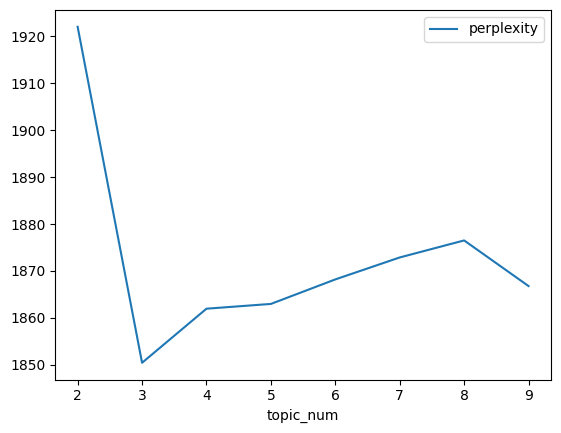

In [21]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

2024-05-17 14:41:57,272 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,275 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,281 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,284 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


2024-05-17 14:41:57,286 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,290 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,296 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,299 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,304 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,308 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 14:41:57,319 : WARNING : findfont: Generic family 'sans-serif' no

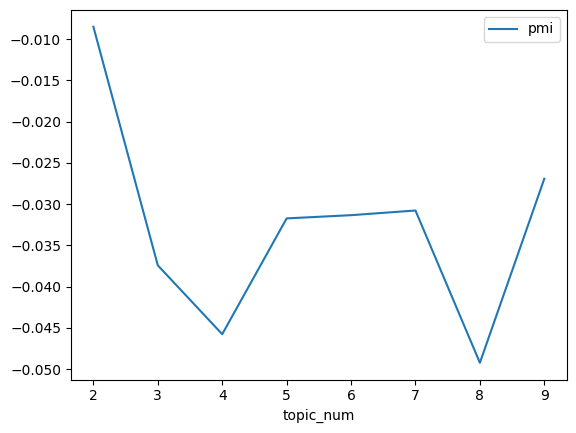

In [22]:
result.plot.line(x='topic_num', y='pmi')

### 視覺化呈現

-  選擇topic=3

In [31]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 2048,
    alpha=0.02,
    eta=0.1,
    iterations=1000,
    passes=20 # 訓練次數
    )

2024-05-17 14:46:29,533 : INFO : using serial LDA version on this node
2024-05-17 14:46:29,544 : INFO : running online (multi-pass) LDA training, 3 topics, 20 passes over the supplied corpus of 618 documents, updating model once every 618 documents, evaluating perplexity every 618 documents, iterating 1000x with a convergence threshold of 0.001000


2024-05-17 14:46:32,986 : INFO : -8.826 per-word bound, 453.8 perplexity estimate based on a held-out corpus of 618 documents with 88060 words
2024-05-17 14:46:32,987 : INFO : PROGRESS: pass 0, at document #618/618
2024-05-17 14:46:35,043 : INFO : topic #0 (0.020): 0.010*"買房" + 0.010*"台灣" + 0.009*"年輕人" + 0.007*"房價" + 0.007*"年級" + 0.006*"工作" + 0.006*"房子" + 0.006*"政府" + 0.006*"努力" + 0.006*"專家"
2024-05-17 14:46:35,044 : INFO : topic #1 (0.020): 0.020*"台灣" + 0.010*"房價" + 0.009*"年輕人" + 0.008*"工作" + 0.008*"買房" + 0.008*"政府" + 0.007*"房子" + 0.006*"努力" + 0.006*"經濟" + 0.006*"社會"
2024-05-17 14:46:35,045 : INFO : topic #2 (0.020): 0.017*"工作" + 0.008*"努力" + 0.008*"房子" + 0.008*"買房" + 0.007*"問卦" + 0.006*"小孩" + 0.006*"人生" + 0.006*"社會" + 0.005*"年輕人" + 0.005*"台灣"
2024-05-17 14:46:35,049 : INFO : topic diff=1.290754, rho=1.000000
2024-05-17 14:46:35,928 : INFO : -7.638 per-word bound, 199.2 perplexity estimate based on a held-out corpus of 618 documents with 88060 words
2024-05-17 14:46:35,930 : INFO : PR

In [32]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.041042 -0.098305       1        1  48.712362
2     -0.147974  0.025411       2        1  29.605890
0      0.106932  0.072895       3        1  21.681747, topic_info=     Term        Freq       Total Category  logprob  loglift
12     工作  854.000000  854.000000  Default  30.0000  30.0000
1004   年級  359.000000  359.000000  Default  29.0000  29.0000
417    放棄  207.000000  207.000000  Default  28.0000  28.0000
892   八年級  200.000000  200.000000  Default  27.0000  27.0000
991   七年級  178.000000  178.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
48     房子  103.659887  625.585618   Topic3  -5.2160  -0.2689
395    不生   84.196073  328.158860   Topic3  -5.4239   0.1683
1265  民進黨   77.798816  290.941483   Topic3  -5.5029   0.2097
201    政府   76.594747  566.712669   Topic3  -5.5185  -0.4726
509    垃圾   72.152951  233.208571   Topic3  -5.5783   0.3556

[268 rows x 6 columns], token_table=      Topic      Freq Term
term                      
475       1  0.203982   一代
475       2  0.731936   一代
475       3  0.071994   一代
991       1  0.028017  七年級
991       2  0.028017  七年級
...     ...       ...  ...
826       1  0.995917   香港
2606      1  0.928298   高雄
2606      2  0.034811   高雄
2606      3  0.034811   高雄
3515      2  0.983589   鷹架

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [21]:
pyLDAvis.save_html(p, "lda_zh.html")

### 主題分析
| 主題 | 關鍵字 | 主題議題 | 
| --- | --- | --- | 
| 1 | 年輕人、房價、炒房、買房、買不起、薪資、未來 |  | 
| 2 | 工作、小孩、上班、生活、結婚、賺錢、不婚、人生 |  | 
| 3 | 年紀、七年級、八年級、努力、經濟、房貸、存款、學生 |  | 


In [22]:
# 取得每筆發文的主題分佈
topics_doc = best_model.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:10])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]
newDocList = []
for i in doc_list:
    x = i + 1
    newDocList.append(x)
# print(newDocList)

[[0.6447943, 0.026445286, 7.561192e-05, 7.561192e-05, 0.32860917], [8.344371e-05, 0.17126206, 0.82848763, 8.344371e-05, 8.344371e-05], [0.19695172, 0.42233467, 0.22024874, 7.920004e-05, 0.16038568], [0.35015407, 0.53997064, 0.00010484851, 0.00010484851, 0.10966563], [0.34303045, 0.00011914477, 0.65661216, 0.00011914477, 0.00011914477], [0.029863011, 0.00014192652, 0.96971124, 0.00014192652, 0.00014192652], [0.00012135534, 0.00012135534, 0.9500706, 0.04956533, 0.00012135534], [5.689833e-05, 5.689833e-05, 0.49658564, 5.689833e-05, 0.5032437], [0.5565964, 0.14653648, 9.319841e-05, 9.319841e-05, 0.2966807], [4.7135753e-05, 4.7135753e-05, 0.9910776, 0.008781003, 4.7135753e-05]]


In [23]:
topic_ptt = ptt.copy()

In [24]:
# 將結果放進 DataFrame 裡
topic_ptt['topic'] = newDocList

In [25]:
topic_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01 07:55:23,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ...",1
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01 12:46:20,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐...",3
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01 13:04:23,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,...",2
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01 14:24:44,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,...",2
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01 17:29:26,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生...",3


#### 時間分佈

In [26]:
# 轉換時間格式
topic_ptt['artDate'] = pd.to_datetime(topic_ptt['artDate'])
topic_ptt["artDate"] = topic_ptt["artDate"].dt.date


In [27]:
topic_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ...",1
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐...",3
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,...",2
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,...",2
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生...",3


In [28]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':topic_ptt.groupby(['artDate','topic']).size()
})
date_topic = date_topic.reset_index()
date_topic = date_topic.groupby([date_topic['artDate'],'topic']).sum().reset_index()

In [29]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic1', 'topic2','topic3','topic4','topic5']
date_df

,artDate,topic1,topic2,topic3,topic4,topic5
0,2022-05-01,1.0,2.0,4.0,0.0,0.0
1,2022-05-02,0.0,0.0,0.0,1.0,1.0
2,2022-05-03,1.0,0.0,1.0,1.0,0.0
3,2022-05-04,1.0,0.0,0.0,0.0,1.0
4,2022-05-05,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
380,2023-05-26,2.0,0.0,0.0,0.0,3.0
381,2023-05-27,0.0,0.0,0.0,1.0,1.0
382,2023-05-28,1.0,0.0,2.0,0.0,0.0
383,2023-05-29,0.0,2.0,2.0,2.0,3.0


In [30]:
pickDate_df = date_df.copy()
pickDate_df['total'] = pickDate_df.apply(lambda x: x['topic1']+x['topic2']+x['topic3']+x['topic4']+x['topic5'], axis=1)
pickDate_df.sort_values('total', ascending=False, inplace=True)
index = pickDate_df.head(1).index.values[0]
new_pickDate_df=date_df[index:index+7]
new_pickDate_df

,artDate,topic1,topic2,topic3,topic4,topic5
79,2022-07-22,0.0,7.0,1.0,2.0,17.0
80,2022-07-23,1.0,3.0,4.0,0.0,6.0
81,2022-07-24,1.0,2.0,1.0,2.0,1.0
82,2022-07-25,1.0,3.0,0.0,0.0,0.0
83,2022-07-26,1.0,3.0,0.0,2.0,2.0
84,2022-07-27,1.0,0.0,1.0,0.0,0.0
85,2022-07-29,0.0,1.0,1.0,0.0,1.0


- 2022/7/22 知名藝人林志穎駕駛特斯拉Model X失控自撞分隔島，導致車輛起火，燒成廢鐵，我們推測可能是因為這個新聞，導致當週的討論量提升，可以看到topic2及topic3的討論量都有所提升．

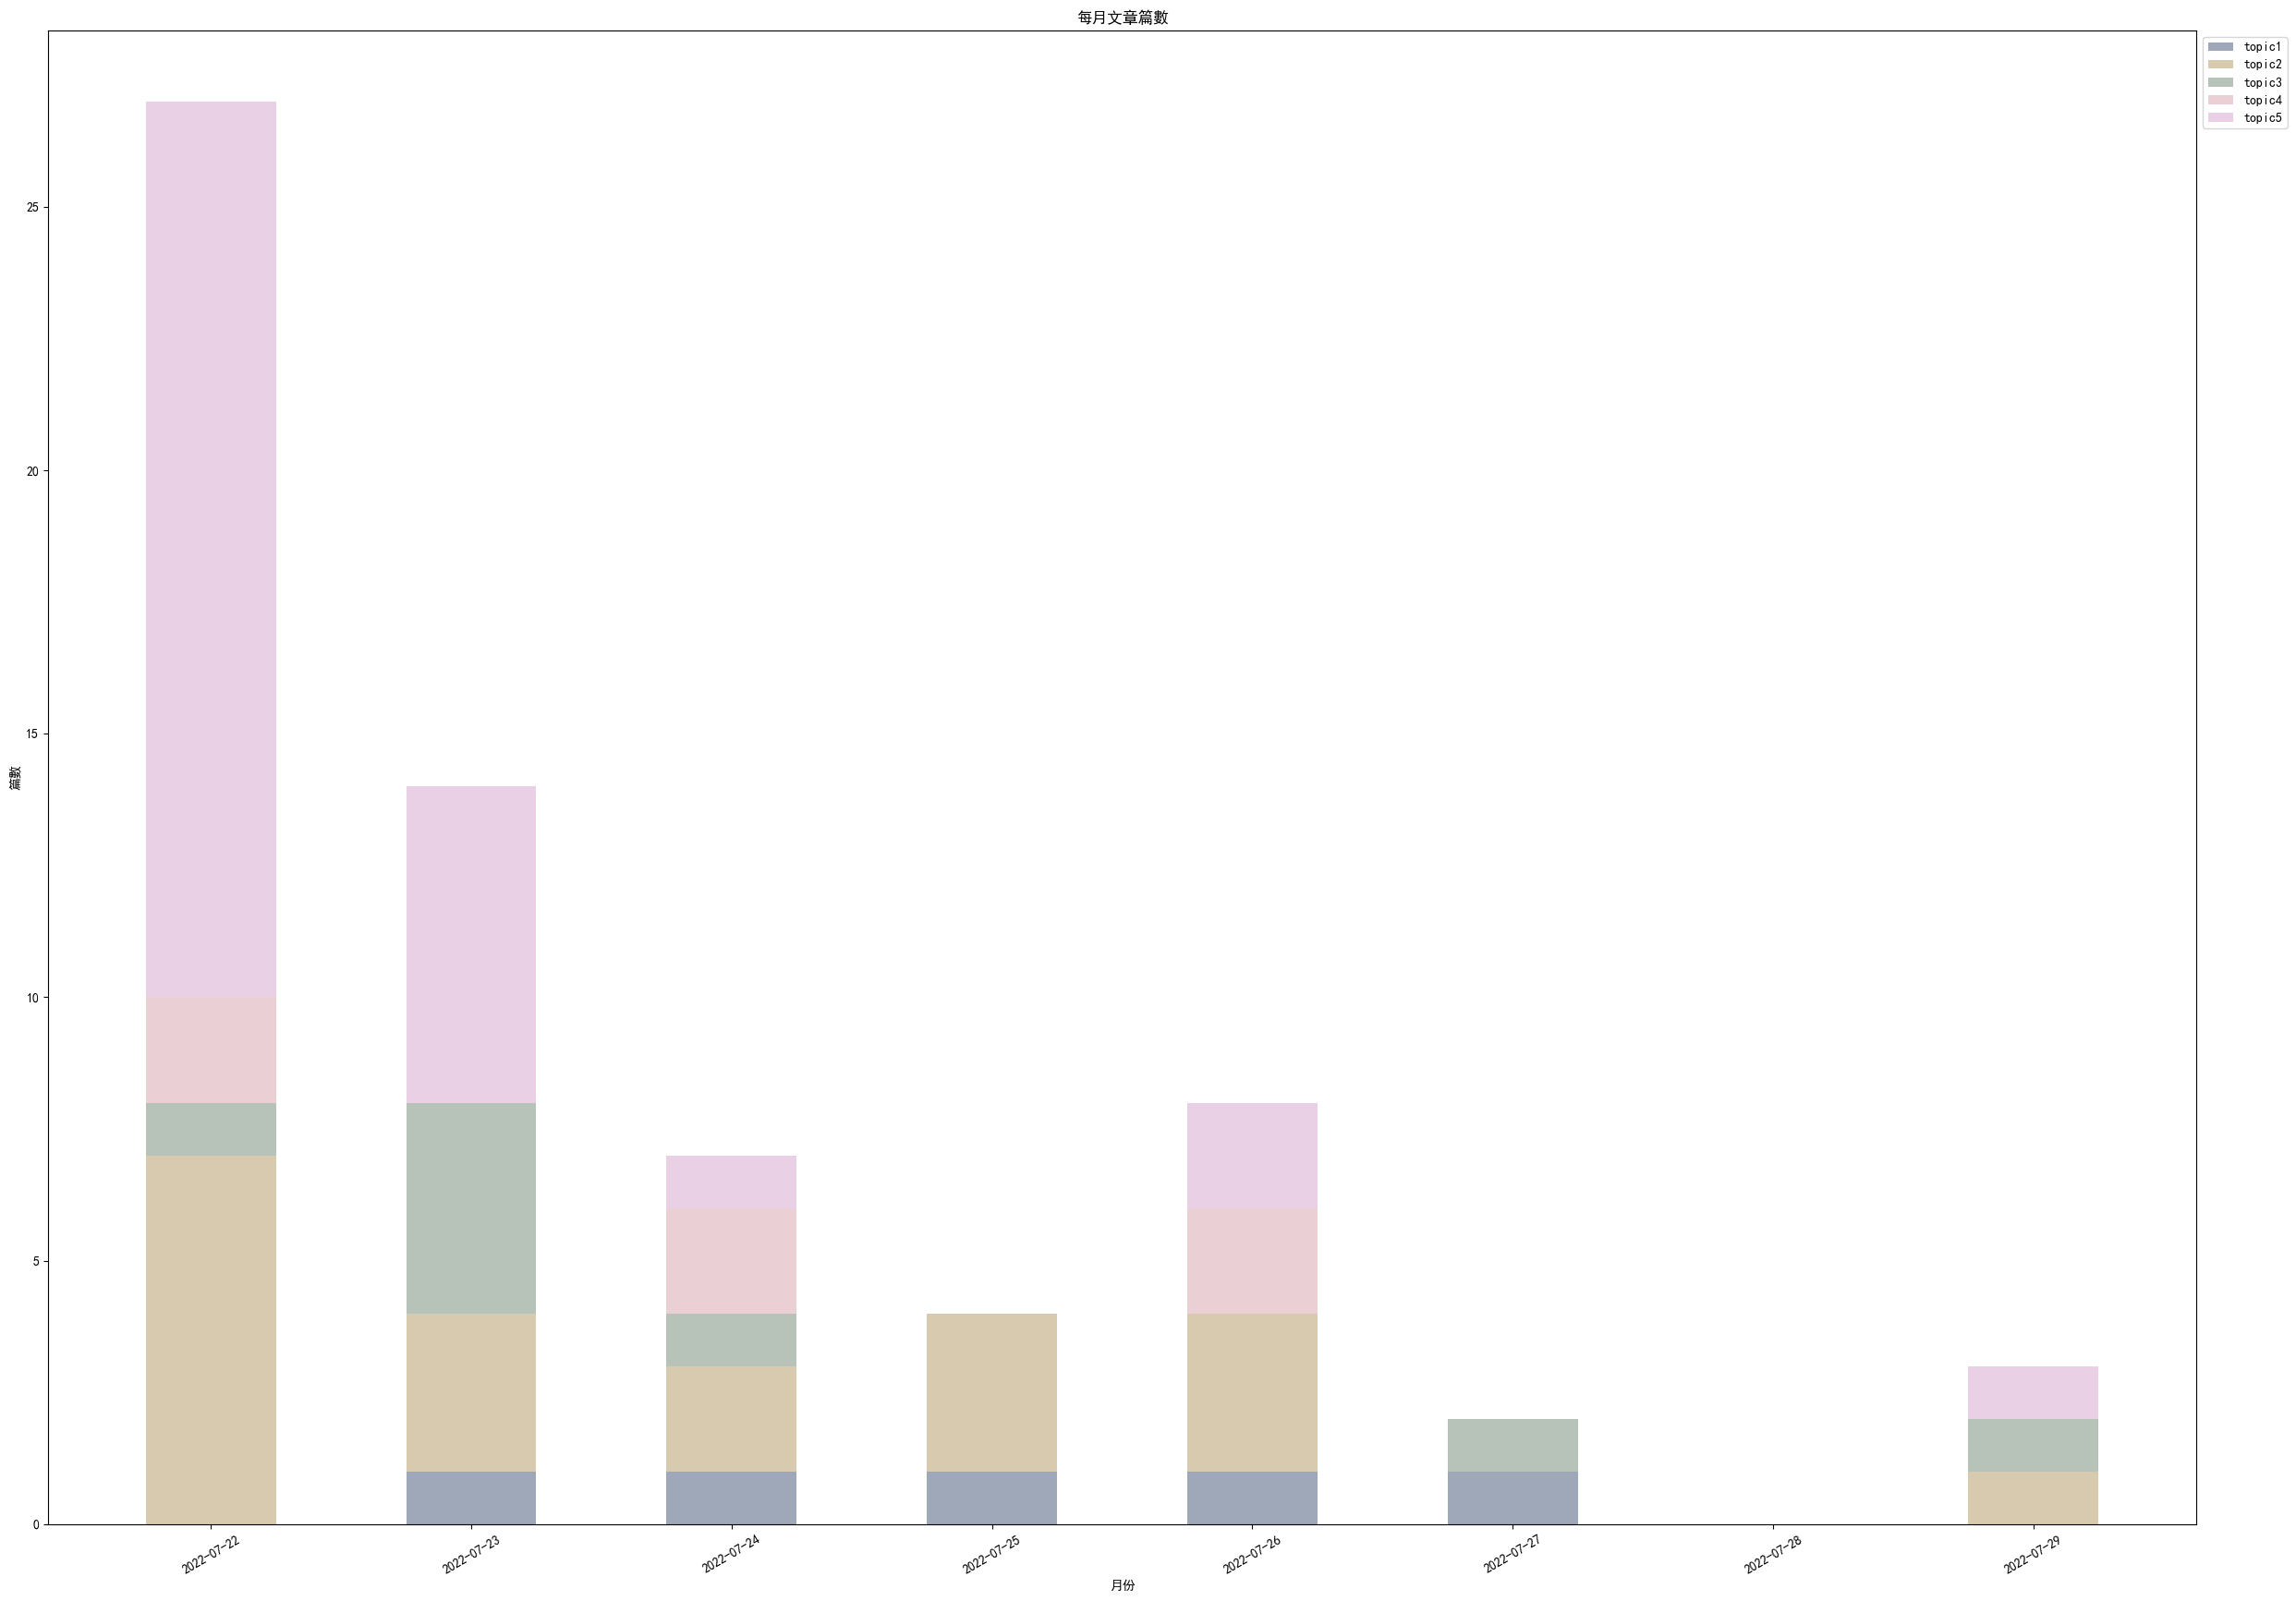

In [31]:
plt.subplots(figsize=(30, 21))
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5","#EAD0E5"]
column = ['topic1', 'topic2', 'topic3','topic4','topic5']
temp_bottom = 0

for i in range(0,5):
    if(i>0):
        temp_bottom = temp_bottom + new_pickDate_df[column[i-1]]
        plt.bar(new_pickDate_df.artDate, new_pickDate_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(new_pickDate_df.artDate, new_pickDate_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

## 6. 主題情緒分析

### 使用SnowNLP進行情緒分析

In [32]:
senti_ptt = topic_ptt.copy()

In [33]:
# 清除型態不符的資料
index_to_drop = senti_ptt[senti_ptt['whole_content'].apply(lambda x: isinstance(x, float))].index
senti_ptt = senti_ptt.drop(index_to_drop)

In [34]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

In [35]:
# 幫每篇文章加上情緒分數
senti_ptt['sentimentValue'] = senti_ptt.apply(lambda row : get_sentiment(row['whole_content'],) , axis=1)
senti_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic,sentimentValue
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ...",1,3.061966e-07
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐...",3,0.000000e+00
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,...",2,0.000000e+00
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,...",2,0.000000e+00
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生...",3,0.000000e+00


### 針對5個主題個別進行分析

In [36]:
topic1_sentiment = senti_ptt[senti_ptt['topic']==1]  
topic2_sentiment = senti_ptt[senti_ptt['topic']==2] 
topic3_sentiment = senti_ptt[senti_ptt['topic']==3] 
topic4_sentiment = senti_ptt[senti_ptt['topic']==4] 
topic5_sentiment = senti_ptt[senti_ptt['topic']==5] 

Topic 1 : 電動車常討論到的議題

In [37]:
# 看一下情緒的分布
topic1_sentiment['sentimentValue'].describe()

count    1.470000e+02
mean     2.367683e-07
std      2.111980e-06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.482289e-05
Name: sentimentValue, dtype: float64

<Axes: >

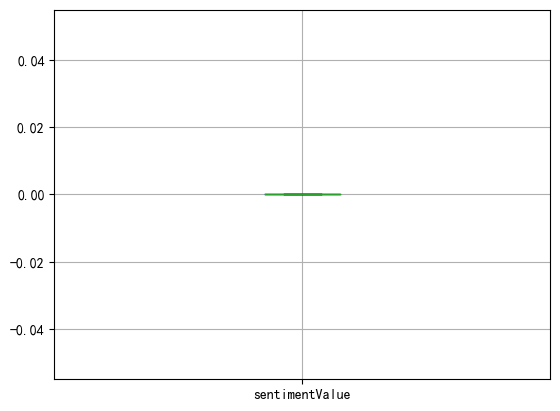

In [38]:
# 看一下情緒的分布
topic1_sentiment['sentimentValue'].describe()

# 情緒分布的盒狀圖
boxplot = topic1_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 此圖可以看到此主題沒有什麼情緒，可見大家都很理性的討論有關特斯拉相關的議題，像是車位或充電等等

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\713993082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic1_sentiment['artDate'] =  pd.to_datetime(topic1_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\713993082.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


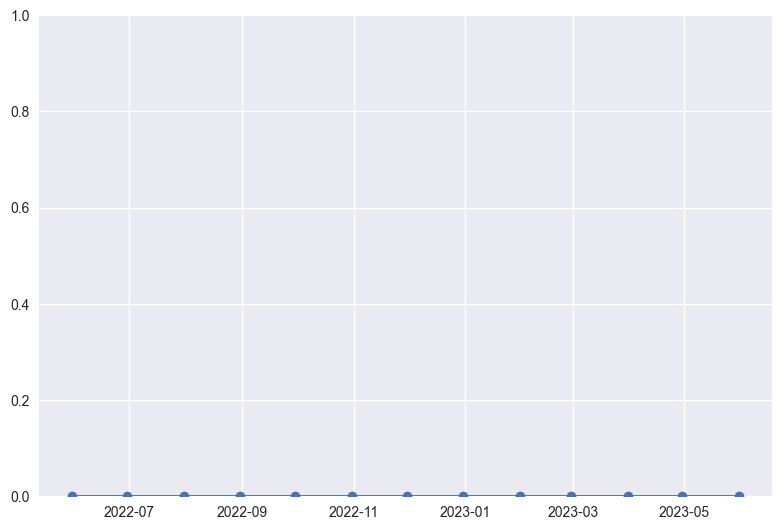

In [39]:
# 將每個月的情緒分數取平均
topic1_sentiment['artDate'] =  pd.to_datetime(topic1_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic1_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 2 : 全球電動車的發展及市場

In [40]:
# 看一下情緒的分布
topic2_sentiment['sentimentValue'].describe()

count    2.290000e+02
mean     5.908369e-02
std      2.308005e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.134648e-13
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

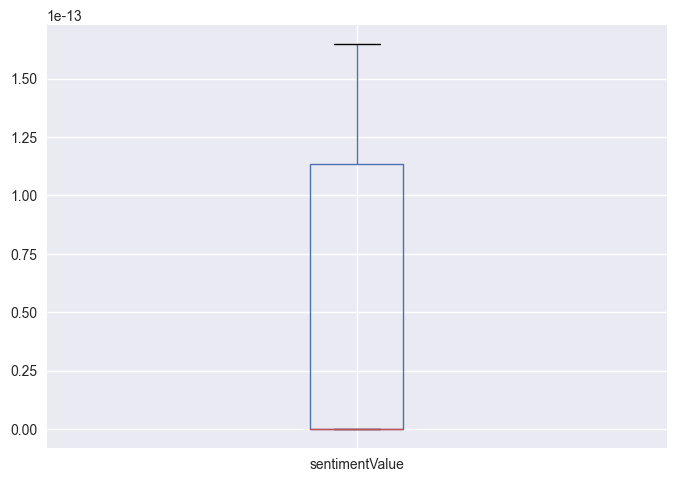

In [41]:
# 情緒分布的盒狀圖
boxplot = topic2_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 這邊可以看到中位數是位於盒子的下半部分，表示情緒偏向於負向，可能是因為此主題探討的範圍有關電池及環保問題，而特斯拉的電池爆炸會產生有毒物質會污染環境，我們推測可能是因為此原因輿論的情緒才比較偏負向

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4212522119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic2_sentiment['artDate'] =  pd.to_datetime(topic2_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4212522119.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


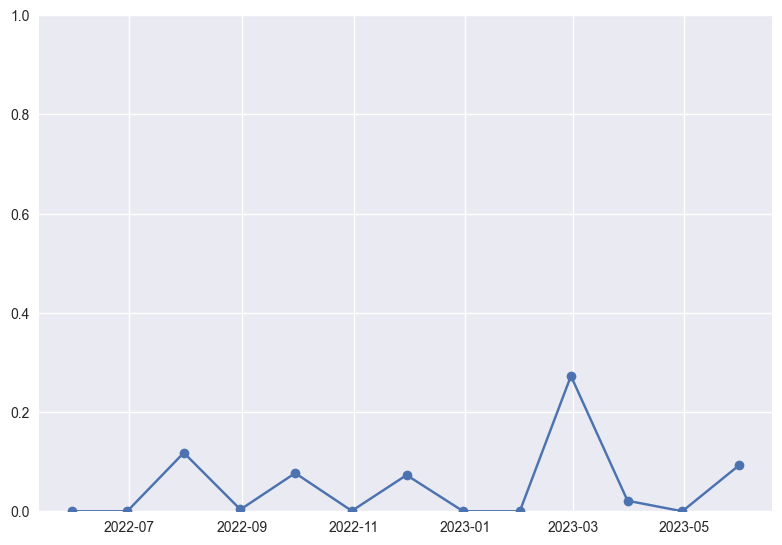

In [42]:
# 將每個月的情緒分數取平均
topic2_sentiment['artDate'] =  pd.to_datetime(topic2_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic2_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 3 : 特斯拉相關的新聞

In [43]:
# 看一下情緒的分布
topic3_sentiment['sentimentValue'].describe()

count    6.220000e+02
mean     9.789485e-02
std      2.914617e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.082939e-11
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

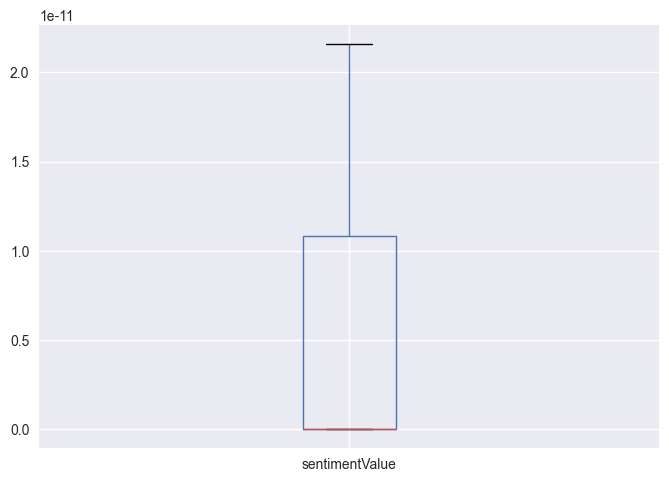

In [44]:
# 情緒分布的盒狀圖
boxplot = topic3_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 這邊可以看到中位數是位於盒子的下半部分，表示情緒偏向於負向，我們推測偏負向可能是因為此主題比較偏特斯拉車禍自撞或駕駛室三寶的新聞，因此輿論的情緒可能會負面．

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\120993594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic3_sentiment['artDate'] =  pd.to_datetime(topic3_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\120993594.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


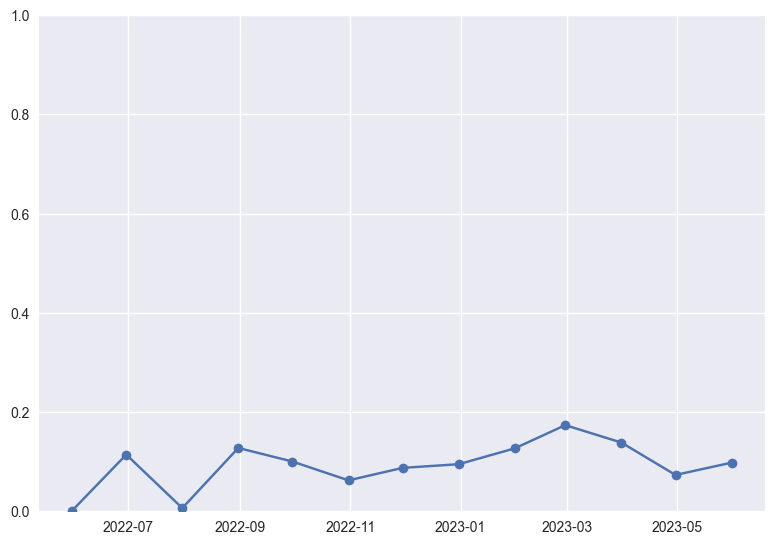

In [45]:
# 將每個月的情緒分數取平均
topic3_sentiment['artDate'] =  pd.to_datetime(topic3_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic3_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 4 : 購車會考量的因素

In [46]:
# 看一下情緒的分布
topic4_sentiment['sentimentValue'].describe()

count    2.500000e+02
mean     4.974353e-02
std      1.953098e-01
min      0.000000e+00
25%      0.000000e+00
50%      2.213008e-12
75%      5.148000e-07
max      9.995214e-01
Name: sentimentValue, dtype: float64

<Axes: >

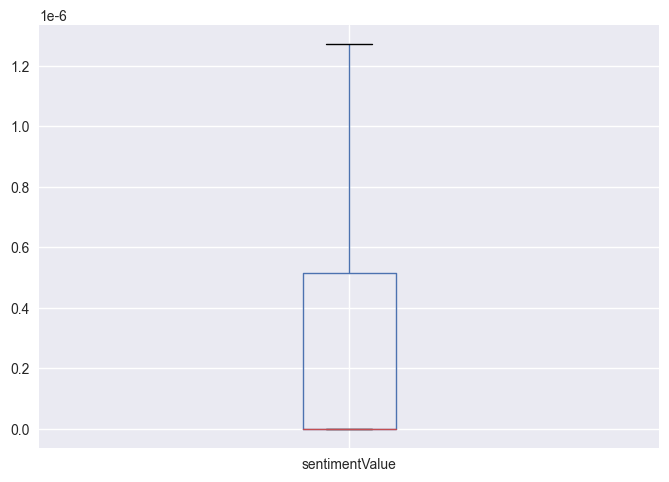

In [47]:
# 情緒分布的盒狀圖
boxplot = topic4_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 這邊可以看到中位數是位於盒子的下半部分，表示情緒偏向於負向，推測可能是因為車子的買家想買的車子價格太高不符合預算，才造成較負面的情緒．

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4262786616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic4_sentiment['artDate'] =  pd.to_datetime(topic4_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4262786616.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


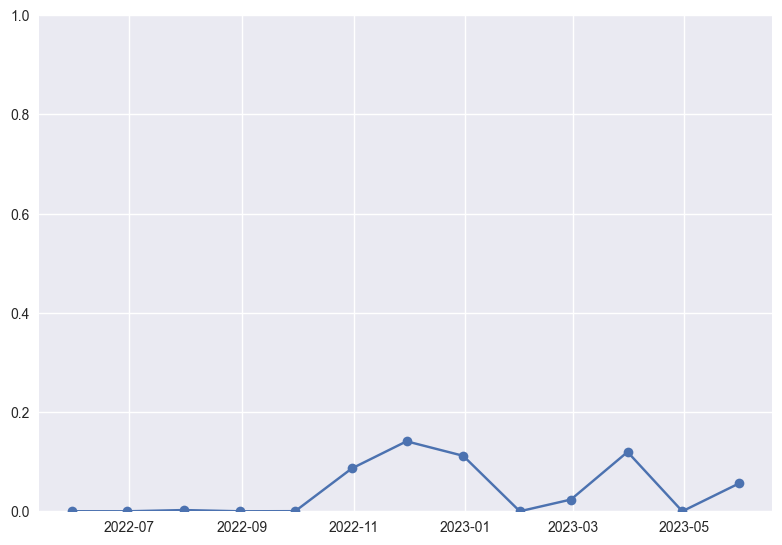

In [48]:
# 將每個月的情緒分數取平均
topic4_sentiment['artDate'] =  pd.to_datetime(topic4_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic4_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 5 : 車輛買賣相關資訊

In [49]:
# 看一下情緒的分布
topic5_sentiment['sentimentValue'].describe()

count    963.000000
mean       0.018780
std        0.127228
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: sentimentValue, dtype: float64

<Axes: >

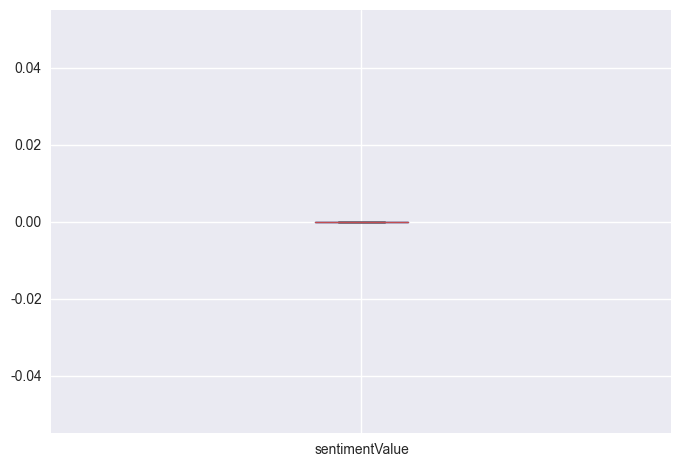

In [50]:
# 情緒分布的盒狀圖
boxplot = topic5_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 圖中可以看到輿論對於此主題沒有什麼情緒起伏，可見輿論非常理性在討論電動車買賣的相關資訊

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4170597695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic5_sentiment['artDate'] =  pd.to_datetime(topic5_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4170597695.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


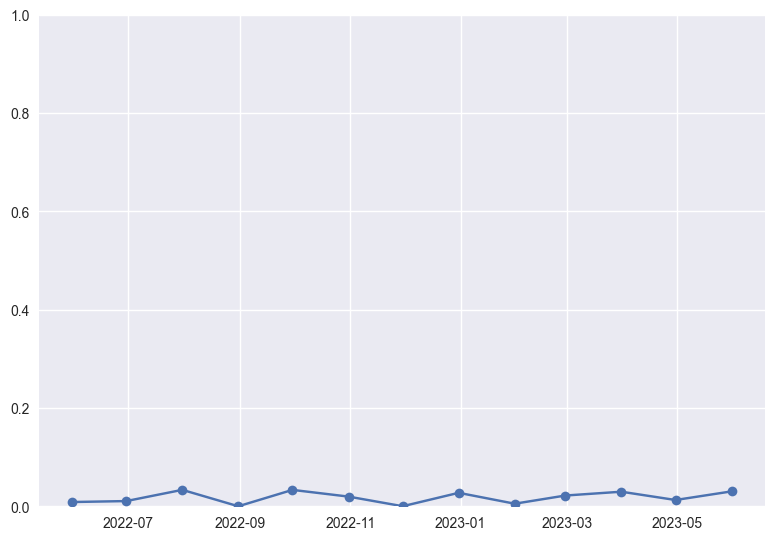

In [51]:
# 將每個月的情緒分數取平均
topic5_sentiment['artDate'] =  pd.to_datetime(topic5_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic5_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

## 7. 結論

從我們上面做的主題探討及輿情分析，我們可以看出電動車大致有分成以上這5個主題，以及個主題輿論討論的情緒分佈．

#### 影片連結
<a href="https://youtu.be/cELzcZ8sFxQ">影片連結</a>